In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import re

lemmatizer = WordNetLemmatizer()

In [292]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

In [293]:
pd.options.display.max_info_rows = 500
pd.options.display.max_info_columns = 500

In [294]:
networking_df = pd.read_csv('../datasets/networking.csv')
networking_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video
0,NaN,networking,"Hi All,\nIn order to stem off a flood of quest...",t2_rm62wli,False,NaN,0,False,COVID-19 Superthread: Discuss your BCP/VPN que...,[],r/networking,False,6,NaN,0,False,t3_fh6989,False,dark,0.92,NaN,public,191,0,{},69d38852-ff47-11e0-8dbe-12313d192a33,False,[],NaN,False,False,NaN,{},NaN,False,191,NaN,False,NaN,1583968932.0,NaN,[],{},NaN,True,NaN,1583996670.0,text,6,NaN,NaN,text,self.networking,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,Moderator | Sr. Network Diplomat,[],False,NaN,NaN,moderator,t5_2qkaf,NaN,NaN,NaN,fh6989,True,NaN,OhMyInternetPolitics,NaN,257,False,all_ads,False,[],False,dark,/r/networking/comments/fh6989/covid19_superthr...,all_ads,True,https://www.reddit.com/r/networking/comments/f...,204818,1583967870.0,1,NaN,False
1,NaN,networking,It's Wednesday! Time to get that crap that's b...,t2_6l4z3,False,NaN,0,False,Rant Wednesday!,[],r/networking,False,6,NaN,0,False,t3_ginoe8,False,dark,0.68,NaN,public,5,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,5,NaN,True,NaN,False,NaN,[],{},NaN,True,NaN,1589357047.0,text,6,NaN,NaN,text,self.networking,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,moderator,t5_2qkaf,NaN,NaN,NaN,ginoe8,True,NaN,AutoModerator,NaN,14,False,all_ads,False,[],False,NaN,/r/networking/comments/ginoe8/rant_wednesday/,all_ads,True,https://www.reddit.com/r/networking/comments/g...,204818,1589328247.0,0,NaN,False
2,NaN,networking,"Hi all,\n\nSo I've just started a new role whe...",t2_14ishx,False,NaN,0,False,Visio alternative for Network diagrams,[],r/networking,False,6,NaN,0,False,t3_gj88ul,False,dark,0.9,NaN,public,83,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,83,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1589434204.0,text,6,NaN,NaN,text,self.networking,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qkaf,NaN,NaN,NaN,gj88ul,True,NaN,lancejack2,NaN,71,True,all_ads,False,[],False,NaN,/r/networking/comments/gj88ul/visio_alternativ...,all_ads,False,https://www.reddit.com/r/networking/comments/g...,204818,1589405404.0,0,NaN,False
3,NaN,networking,I could use a brain check/fresh minds on this....,t2_4d30h,False,NaN,0,False,Cisco ASA to Sonicwall VPN - can't get the Cis...,[],r/networking,False,6,NaN,0,False,t3_gjdubc,False,dark,1.0,NaN,public,6,0,{},46699a82-fef7-11e0-81b7-12313d18ad57,False,[],NaN,False,False,NaN,{},NaN,False,6,NaN,False,NaN,1589425831.0,NaN,[],{},NaN

In [295]:
networking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 101 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   approved_at_utc                4 non-null      object
 1   subreddit                      139 non-null    object
 2   selftext                       139 non-null    object
 3   author_fullname                139 non-null    object
 4   saved                          139 non-null    object
 5   mod_reason_title               4 non-null      object
 6   gilded                         139 non-null    object
 7   clicked                        139 non-null    object
 8   title                          139 non-null    object
 9   link_flair_richtext            139 non-null    object
 10  subreddit_name_prefixed        139 non-null    object
 11  hidden                         139 non-null    object
 12  pwls                           139 non-null    object
 13  link

In [296]:
networking_df.shape

(139, 101)

In [297]:
#delete column names that duplicated with each append to CSV
delete_column_names = networking_df.loc[networking_df['selftext']=='selftext']
delete_column_names

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video
27,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video
55,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video
83,approved_at_

In [298]:
networking_df.drop(delete_column_names.index, inplace=True)

In [299]:
#dealing with duplicates - df1.drop_duplicates(subset='selftext')
networking_df.drop_duplicates(subset='selftext', inplace=True)

In [300]:
networking_df['name'].value_counts()

t3_git8d4    1
t3_gj1u6h    1
t3_gjffvu    1
t3_gjc14z    1
t3_git83w    1
t3_giy6ra    1
t3_gj3q79    1
t3_gj9n09    1
t3_gjdkgx    1
t3_gjaxxt    1
t3_gj1t9f    1
t3_gjcpbb    1
t3_gizvm3    1
t3_gjex4t    1
t3_giyiov    1
t3_giueiz    1
t3_gja6fd    1
t3_gja5b9    1
t3_gj3v4x    1
t3_gj4cpt    1
t3_gj88ul    1
t3_gj74dh    1
t3_gj5g7a    1
t3_gjdubc    1
t3_giixbx    1
t3_ginoe8    1
t3_fh6989    1
Name: name, dtype: int64

In [301]:
networking_df.shape

(27, 101)

In [302]:
networking_m_df = pd.read_csv('../datasets/networking_m.csv')

/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (101,102,103) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [303]:
networking_m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32160 entries, 0 to 32159
Data columns (total 104 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   approved_at_utc                object
 1   subreddit                      object
 2   selftext                       object
 3   author_fullname                object
 4   saved                          object
 5   mod_reason_title               object
 6   gilded                         object
 7   clicked                        object
 8   title                          object
 9   link_flair_richtext            object
 10  subreddit_name_prefixed        object
 11  hidden                         object
 12  pwls                           object
 13  link_flair_css_class           object
 14  downs                          object
 15  hide_score                     object
 16  name                           object
 17  quarantine                     object
 18  link_flair_text_color    

In [304]:
networking_m_df.shape

(32160, 104)

In [305]:
#delete column names that duplicated with each append to CSV
delete_column_names = networking_m_df.loc[networking_m_df['selftext']=='selftext']
delete_column_names

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday,crosspost_parent_list,crosspost_parent
1238,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday,crosspost_parent_list,crosspost_parent
2477,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,pare

In [306]:
networking_m_df.drop(delete_column_names.index, inplace=True)

In [307]:
networking_m_df.shape

(32131, 104)

In [308]:
#dealing with duplicates - df1.drop_duplicates(subset='selftext')
networking_m_df.drop_duplicates(subset='selftext', inplace=True)

In [309]:
networking_m_df['name'].value_counts()

t3_gjiohd    2
t3_gjlfud    2
t3_gji8bv    2
t3_gaxlsg    1
t3_gazp1a    1
            ..
t3_ggblfx    1
t3_geloje    1
t3_gj9n09    1
t3_fz3bs4    1
t3_ghekea    1
Name: name, Length: 820, dtype: int64

In [310]:
networking_m_df.drop_duplicates(subset='name', inplace=True)

In [311]:
networking_m_df.shape

(820, 104)

In [312]:
networking_m_df['name'].value_counts()

t3_gaxlsg    1
t3_ftmhqa    1
t3_gazp1a    1
t3_gbgp5w    1
t3_gj3v4x    1
            ..
t3_g9f2n6    1
t3_ft1dc6    1
t3_ggblfx    1
t3_geloje    1
t3_ghekea    1
Name: name, Length: 820, dtype: int64

In [313]:
#handing time data, converting UTC
#https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
#epoch_t = 1529272655
#real_t = pd.to_datetime(epoch_t, unit='s')
cols_of_interest = ['name', 
                    'selftext', 
                    'title', 
                    'subreddit_name_prefixed', 
                    'upvote_ratio', 
                    'ups', 
                    'created',
                    'num_comments',
                    'gildings']

In [314]:
networking_m_df = networking_m_df[cols_of_interest]
networking_m_df.head()

,name,selftext,title,subreddit_name_prefixed,upvote_ratio,ups,created,num_comments,gildings
0,t3_gjffvu,So I have a situation where I'd like to contro...,PBR based on BGP communities?,r/networking,0.6,1,1589460008.0,2,{}
1,t3_gjex4t,I live in a rural area in Canada where the onl...,Rural internet standard,r/networking,0.5,0,1589457794.0,3,{}
2,t3_gjdubc,I could use a brain check/fresh minds on this....,Cisco ASA to Sonicwall VPN - can't get the Cis...,r/networking,1.0,7,1589453491.0,4,{}
3,t3_gjdkgx,I’m just curious on the difficulty of installi...,Cisco firewall,r/networking,0.25,0,1589452406.0,8,{}
4,t3_gjcpbb,I should have asked this years ago. But it daw...,"Break it to me gently: How to tell, what to te...",r/networking,0.5,0,1589449140.0,8,{}


In [315]:
networking_df = networking_df[cols_of_interest]
networking_df.head()

,name,selftext,title,subreddit_name_prefixed,upvote_ratio,ups,created,num_comments,gildings
0,t3_fh6989,"Hi All,\nIn order to stem off a flood of quest...",COVID-19 Superthread: Discuss your BCP/VPN que...,r/networking,0.92,191,1583996670.0,257,{}
1,t3_ginoe8,It's Wednesday! Time to get that crap that's b...,Rant Wednesday!,r/networking,0.68,5,1589357047.0,14,{}
2,t3_gj88ul,"Hi all,\n\nSo I've just started a new role whe...",Visio alternative for Network diagrams,r/networking,0.9,83,1589434204.0,71,{}
3,t3_gjdubc,I could use a brain check/fresh minds on this....,Cisco ASA to Sonicwall VPN - can't get the Cis...,r/networking,1.0,6,1589453491.0,4,{}
4,t3_gj9n09,We are looking to bring a backup internet circ...,Backup internet circuit - same ISP as primary ...,r/networking,0.69,8,1589438564.0,17,{}


In [316]:
networking_final_df = networking_m_df.append(networking_df)
networking_final_df.head()

,name,selftext,title,subreddit_name_prefixed,upvote_ratio,ups,created,num_comments,gildings
0,t3_gjffvu,So I have a situation where I'd like to contro...,PBR based on BGP communities?,r/networking,0.6,1,1589460008.0,2,{}
1,t3_gjex4t,I live in a rural area in Canada where the onl...,Rural internet standard,r/networking,0.5,0,1589457794.0,3,{}
2,t3_gjdubc,I could use a brain check/fresh minds on this....,Cisco ASA to Sonicwall VPN - can't get the Cis...,r/networking,1.0,7,1589453491.0,4,{}
3,t3_gjdkgx,I’m just curious on the difficulty of installi...,Cisco firewall,r/networking,0.25,0,1589452406.0,8,{}
4,t3_gjcpbb,I should have asked this years ago. But it daw...,"Break it to me gently: How to tell, what to te...",r/networking,0.5,0,1589449140.0,8,{}


In [317]:
networking_final_df.isnull().sum()

name                       0
selftext                   1
title                      0
subreddit_name_prefixed    0
upvote_ratio               0
ups                        0
created                    0
num_comments               0
gildings                   0
dtype: int64

In [318]:
networking_final_df.loc[networking_final_df['selftext'].isnull()]

,name,selftext,title,subreddit_name_prefixed,upvote_ratio,ups,created,num_comments,gildings
205,t3_gc3bsf,NaN,Free Certifications and IT Conference Registra...,r/networking,0.97,218,1588438532.0,19,{}


In [319]:
networking_final_df.drop([205], inplace=True)

In [320]:
networking_final_df.shape

(846, 9)

In [321]:
networking_final_df.drop_duplicates(subset='name', inplace=True)

In [322]:
networking_final_df.shape

(819, 9)

In [323]:
networking_final_df['name'].value_counts()

t3_gaxlsg    1
t3_ftmhqa    1
t3_gazp1a    1
t3_gbgp5w    1
t3_gj3v4x    1
            ..
t3_ft1dc6    1
t3_ggblfx    1
t3_geloje    1
t3_gj9n09    1
t3_ghekea    1
Name: name, Length: 819, dtype: int64

In [324]:
networking_final_df.to_csv('../datasets/networking_final.csv')

In [325]:
sysadmin_df = pd.read_csv('../datasets/sysadmin.csv')

In [326]:
sysadmin_df.shape

(139, 106)

In [327]:
#delete column names that duplicated with each append to CSV
delete_column_names = sysadmin_df[sysadmin_df['selftext']=='selftext']
delete_column_names

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,post_hint,preview
27,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,post_hint,preview
55,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mo

In [328]:
sysadmin_df.drop(delete_column_names.index, inplace=True)

In [329]:
#dealing with duplicates - df1.drop_duplicates(subset='selftext')
sysadmin_df.drop_duplicates(subset='selftext', inplace=True)

In [330]:
sysadmin_df['name'].value_counts()

t3_gfyx3s    1
t3_gfgwul    1
t3_gfsyf7    1
t3_gfz0xh    1
t3_gfswmo    1
t3_gfxvhq    1
t3_gfx69x    1
t3_gfvx8u    1
t3_gfsss1    1
t3_gfxynw    1
t3_gfr73a    1
t3_g0uqta    1
t3_gfxq3e    1
t3_gfsmio    1
t3_gfyxj2    1
t3_gfx4pf    1
t3_gfz1xn    1
t3_gftycl    1
t3_gfrduc    1
t3_gfyuo2    1
t3_gfyafe    1
t3_gft83f    1
t3_gfytdh    1
t3_gfyzu5    1
t3_gfyajk    1
t3_gftw81    1
t3_gfysmo    1
t3_gfsuew    1
t3_gfqrhd    1
t3_gftqyn    1
t3_gevuab    1
t3_gf9rb0    1
t3_gfy778    1
t3_gfyt5y    1
t3_gflo4q    1
t3_gfsp9z    1
Name: name, dtype: int64

In [331]:
sysadmin_df.shape

(36, 106)

In [332]:
sysadmin_m_df = pd.read_csv('../datasets/sysadmin_m.csv')

In [333]:
sysadmin_m_df.shape

(12380, 109)

In [334]:
#delete column names that duplicated with each append to CSV
delete_column_names = sysadmin_m_df[sysadmin_m_df['selftext']=='selftext']
delete_column_names

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,post_hint,preview,crosspost_parent_list,crosspost_parent,author_cakeday
1234,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,post_hint,preview,crosspost_parent_list,crosspost_parent,author_cakeday
2473,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_

In [335]:
sysadmin_m_df.drop(delete_column_names.index, inplace=True)

In [336]:
#dealing with duplicates - df1.drop_duplicates(subset='selftext')
sysadmin_m_df.drop_duplicates(subset='selftext', inplace=True)

In [337]:
sysadmin_m_df['name'].value_counts()

t3_gfzqw7    3
t3_gf5xhv    2
t3_gfzbj2    2
t3_gfzn4b    2
t3_gb3hkq    1
            ..
t3_gasble    1
t3_gflo4q    1
t3_gejtm3    1
t3_gai4zg    1
t3_gfuvax    1
Name: name, Length: 950, dtype: int64

In [338]:
sysadmin_m_df.shape

(955, 109)

In [339]:
sysadmin_m_df.loc[sysadmin_m_df['name']== 't3_gfzqw7']

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,post_hint,preview,crosspost_parent_list,crosspost_parent,author_cakeday
4700,NaN,sysadmin,Seriously. \n\nIt won't install with any other...,t2_obgo2,False,NaN,0,False,FFS! It's 2020. Why does the 'Exchange Online ...,[],r/sysadmin,False,6,NaN,0,NaN,True,t3_gfzqw7,False,dark,1.0,NaN,public,1,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},NaN,False,1,NaN,False,self,False,NaN,[],{},NaN,True,NaN,1588994757.0,text,6,NaN,NaN,text,self.sysadmin,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qnp7,NaN,NaN,NaN,gfzqw7,True,NaN,DonZatarra,NaN,0,True,all_ads,False,[],False,NaN,/r/sysadmin/comments/gfzqw7/ffs_its_2020_why_d...,all_ads,False,https://www.reddit.com/r/sysadmin/comments/gfz...,460486,1588965957.0,0,NaN,False,NaN,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN
5939,NaN,sysadmin,Seriously. \n\nIt won't install with any other...,t2_obgo2,False,NaN,0,False,FFS! It's 2020. Why does the 'Exchange Online ...,[],r/sysadmin,False,6,NaN,0,NaN,True,t3_gfzqw7,False,dark,1.0,NaN,public,1,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},NaN,False,1,NaN,False,self,1588966245.0,NaN,[],{},NaN,True,NaN,1588994757.0,text,6,NaN,NaN,text,self.sysadmin,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qnp7,NaN,NaN,NaN,gfzqw7,True,NaN,DonZatarra,NaN,0,True,all_ads,False,[],False,NaN,/r/sysadmin/comments/gfzqw7/ffs_its_2020_why_d...,all_ads,False,https://www.reddit.com/r/sysadmin/comments/gfz...,460485,1588965957.0,0,NaN,False,NaN,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN
8400,NaN,sysadmin,Seriously. \n\nIt won't install with any other...,t2_obgo2,False,NaN,0,False,FFS! It's 2020. Why does the 'Exchange Online ...,[],r/sysadmin,False,6,NaN,0,NaN,True,t3_gfzqw7,False,dark,0.83,NaN,public,4,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},NaN,False,4,NaN,False,self,1588966832.0,NaN,[],{},NaN,True,NaN,1588994757.0,text,6,NaN,NaN,text,self.sysadmin,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qnp7,NaN,NaN,NaN,gfzqw7,True,NaN,DonZatarra,NaN,0,True,all_ads,False,[],False,NaN,/r/sysadmin/comments/gfzqw7/ffs_its_2020_why_d...,all_ads,False,https://www.reddit.com/r/sysadmin/comments/gfz...,460485,1588965957.0,0,NaN,False,NaN,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN


In [340]:
sysadmin_m_df.drop_duplicates(subset='name', inplace=True)

In [341]:
sysadmin_m_df['name'].value_counts()

t3_gb3hkq    1
t3_gdgadu    1
t3_gf711o    1
t3_gelbhy    1
t3_ge4ctd    1
            ..
t3_gasble    1
t3_gflo4q    1
t3_gejtm3    1
t3_gai4zg    1
t3_gfuvax    1
Name: name, Length: 950, dtype: int64

Create subsets of text columns and then combine both CSVs for the chosen subreddits for analysis

In [342]:
#joining columns 'name', 'selftext', 'title'
sysadmin_text_df = sysadmin_df[cols_of_interest]
sysadmin_text_df.head()

,name,selftext,title,subreddit_name_prefixed,upvote_ratio,ups,created,num_comments,gildings
0,t3_gevuab,"Howdy, /r/sysadmin!\n\nIt's that time of the w...","Thickheaded Thursday - May 07, 2020",r/sysadmin,0.74,7,1588838864.0,18,{}
1,t3_g0uqta,Hello [r/sysadmin](https://www.reddit.com/r/sy...,Patch Tuesday Megathread (2020-04-14),r/sysadmin,0.93,69,1586851209.0,128,{}
2,t3_gfsuew,[eaton ups](https://imgur.com/gallery/EPY9XW2),This UPS so captures the current mood!,r/sysadmin,0.94,451,1588971857.0,37,{'gid_2': 1}
3,t3_gf9rb0,"Every quarter, our company holds an Awards ""ce...",IT got recognized in our quarterly awards for ...,r/sysadmin,0.97,1369,1588897595.0,88,{'gid_2': 1}
4,t3_gflo4q,"This morning, someone came into my office aski...",I don't often get recognition for my work but ...,r/sysadmin,0.91,83,1588937935.0,6,{}


In [343]:
sysadmin_text_m_df = sysadmin_m_df[cols_of_interest]
sysadmin_text_m_df.head()

,name,selftext,title,subreddit_name_prefixed,upvote_ratio,ups,created,num_comments,gildings
0,t3_gevuab,"Howdy, /r/sysadmin!\n\nIt's that time of the w...","Thickheaded Thursday - May 07, 2020",r/sysadmin,0.84,9,1588838864.0,18,{}
1,t3_g0uqta,Hello [r/sysadmin](https://www.reddit.com/r/sy...,Patch Tuesday Megathread (2020-04-14),r/sysadmin,0.93,72,1586851209.0,128,{}
2,t3_gfsuew,[eaton ups](https://imgur.com/gallery/EPY9XW2),This UPS so captures the current mood!,r/sysadmin,0.94,489,1588971857.0,38,{'gid_2': 1}
3,t3_gf9rb0,"Every quarter, our company holds an Awards ""ce...",IT got recognized in our quarterly awards for ...,r/sysadmin,0.97,1367,1588897595.0,89,{'gid_2': 1}
4,t3_gflo4q,"This morning, someone came into my office aski...",I don't often get recognition for my work but ...,r/sysadmin,0.92,89,1588937935.0,6,{}


In [344]:
sysadmin_final_df = sysadmin_text_m_df.append(sysadmin_text_df)
sysadmin_final_df.head()

,name,selftext,title,subreddit_name_prefixed,upvote_ratio,ups,created,num_comments,gildings
0,t3_gevuab,"Howdy, /r/sysadmin!\n\nIt's that time of the w...","Thickheaded Thursday - May 07, 2020",r/sysadmin,0.84,9,1588838864.0,18,{}
1,t3_g0uqta,Hello [r/sysadmin](https://www.reddit.com/r/sy...,Patch Tuesday Megathread (2020-04-14),r/sysadmin,0.93,72,1586851209.0,128,{}
2,t3_gfsuew,[eaton ups](https://imgur.com/gallery/EPY9XW2),This UPS so captures the current mood!,r/sysadmin,0.94,489,1588971857.0,38,{'gid_2': 1}
3,t3_gf9rb0,"Every quarter, our company holds an Awards ""ce...",IT got recognized in our quarterly awards for ...,r/sysadmin,0.97,1367,1588897595.0,89,{'gid_2': 1}
4,t3_gflo4q,"This morning, someone came into my office aski...",I don't often get recognition for my work but ...,r/sysadmin,0.92,89,1588937935.0,6,{}


In [345]:
sysadmin_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 0 to 108
Data columns (total 9 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   name                     object
 1   selftext                 object
 2   title                    object
 3   subreddit_name_prefixed  object
 4   upvote_ratio             object
 5   ups                      object
 6   created                  object
 7   num_comments             object
 8   gildings                 object
dtypes: object(9)
memory usage: 77.0+ KB


In [346]:
sysadmin_final_df.isnull().sum()

name                       0
selftext                   1
title                      0
subreddit_name_prefixed    0
upvote_ratio               0
ups                        0
created                    0
num_comments               0
gildings                   0
dtype: int64

In [347]:
sysadmin_final_df.shape

(986, 9)

In [348]:
sysadmin_final_df.drop_duplicates(subset='name', inplace=True)

In [349]:
sysadmin_final_df.shape

(950, 9)

In [350]:
sysadmin_final_df.isnull().sum()

name                       0
selftext                   1
title                      0
subreddit_name_prefixed    0
upvote_ratio               0
ups                        0
created                    0
num_comments               0
gildings                   0
dtype: int64

In [351]:
sysadmin_final_df.loc[sysadmin_final_df['selftext'].isnull()]

,name,selftext,title,subreddit_name_prefixed,upvote_ratio,ups,created,num_comments,gildings
58,t3_gfv8ob,NaN,Lenovo P53s - Weird sleep issue.,r/sysadmin,0.66,1,1588980573.0,0,{}


In [352]:
#found a post without post content, dropping this row
sysadmin_final_df.drop([58], inplace=True)

In [353]:
sysadmin_final_df.shape

(949, 9)

In [354]:
sysadmin_final_df.to_csv('../datasets/sysadmin_final.csv')

In [355]:
#combine posts from two subreddits
sysadmin_networking = pd.concat([networking_final_df, sysadmin_final_df], ignore_index=True)

In [356]:
sysadmin_networking.head()

,name,selftext,title,subreddit_name_prefixed,upvote_ratio,ups,created,num_comments,gildings
0,t3_gjffvu,So I have a situation where I'd like to contro...,PBR based on BGP communities?,r/networking,0.6,1,1589460008.0,2,{}
1,t3_gjex4t,I live in a rural area in Canada where the onl...,Rural internet standard,r/networking,0.5,0,1589457794.0,3,{}
2,t3_gjdubc,I could use a brain check/fresh minds on this....,Cisco ASA to Sonicwall VPN - can't get the Cis...,r/networking,1.0,7,1589453491.0,4,{}
3,t3_gjdkgx,I’m just curious on the difficulty of installi...,Cisco firewall,r/networking,0.25,0,1589452406.0,8,{}
4,t3_gjcpbb,I should have asked this years ago. But it daw...,"Break it to me gently: How to tell, what to te...",r/networking,0.5,0,1589449140.0,8,{}


In [357]:
#update it to take the reddit's own column
sysadmin_networking['sysadmin'] = [1 if sysadmin_networking.loc[i, 'subreddit_name_prefixed']== 'r/sysadmin' 
                                 else 0 for i in range(sysadmin_networking.shape[0])]

In [358]:
sysadmin_networking.isnull().sum()

name                       0
selftext                   0
title                      0
subreddit_name_prefixed    0
upvote_ratio               0
ups                        0
created                    0
num_comments               0
gildings                   0
sysadmin                   0
dtype: int64

In [359]:
sysadmin_networking.shape

(1768, 10)

In [360]:
sysadmin_networking.head()

,name,selftext,title,subreddit_name_prefixed,upvote_ratio,ups,created,num_comments,gildings,sysadmin
0,t3_gjffvu,So I have a situation where I'd like to contro...,PBR based on BGP communities?,r/networking,0.6,1,1589460008.0,2,{},0
1,t3_gjex4t,I live in a rural area in Canada where the onl...,Rural internet standard,r/networking,0.5,0,1589457794.0,3,{},0
2,t3_gjdubc,I could use a brain check/fresh minds on this....,Cisco ASA to Sonicwall VPN - can't get the Cis...,r/networking,1.0,7,1589453491.0,4,{},0
3,t3_gjdkgx,I’m just curious on the difficulty of installi...,Cisco firewall,r/networking,0.25,0,1589452406.0,8,{},0
4,t3_gjcpbb,I should have asked this years ago. But it daw...,"Break it to me gently: How to tell, what to te...",r/networking,0.5,0,1589449140.0,8,{},0


In [361]:
sysadmin_networking.rename(columns={'selftext': 'posts'}, inplace=True)

In [362]:
sysadmin_networking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 10 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   name                     object
 1   posts                    object
 2   title                    object
 3   subreddit_name_prefixed  object
 4   upvote_ratio             object
 5   ups                      object
 6   created                  object
 7   num_comments             object
 8   gildings                 object
 9   sysadmin                 int64 
dtypes: int64(1), object(9)
memory usage: 138.2+ KB


In [363]:
sysadmin_networking.to_csv('../datasets/sysadmin_networking.csv')

## Train/Test Split
Spliting our Train and Test datasets

usually i go for 80/20
do rem cv=10
Split Train 80%  ( Test 20 )
Then Train split , 80% Train, 20% valid
you compare models using valid
choose the model

https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

In [364]:
sysadmin_networking['posts']

0       So I have a situation where I'd like to contro...
1       I live in a rural area in Canada where the onl...
2       I could use a brain check/fresh minds on this....
3       I’m just curious on the difficulty of installi...
4       I should have asked this years ago. But it daw...
                              ...                        
1763    So I was in a call with bossman and a MSP to t...
1764    What do you use for a cheap NAS. Doesn’t need ...
1765    I used the dell restore point  on a Dell 3420 ...
1766     \n\nNot sure if this is correct place but i h...
1767    Looking to tap that sweet sweet hive mind. Iss...
Name: posts, Length: 1768, dtype: object

In [365]:
X_train, X_test, y_train, y_test = train_test_split(sysadmin_networking[['posts']],
                                                    sysadmin_networking['sysadmin'],
                                                    test_size= 0.20,
                                                    random_state=42,
                                                    shuffle=True)

In [366]:
X_train.shape

(1414, 1)

In [367]:
y_train.shape

(1414,)

In [368]:
np.bincount(y_train)

array([649, 765])

## Remove Stopwords

In [370]:
# add reddit subreddit titles to stopwords
# added stopwords from features that were least important for classification by our model 
stop_words = set(stopwords.words('english'))
new_stopwords = ['sysadmin', 
                 'networking', 
                 'network', 
                 'system', 
                 'administrator', 
                 'admin',
                 'aa',
                 'nmq',
                 'nmkhloig',
                 'nla', 
                 'nky', 
                 'nkp', 
                 'nkiiq', 
                 'njzivxfgl',   
                 'niq', 
                 'nil']
new_stopwords_list = stop_words.union(new_stopwords)

custom_stopwords = set([word for word in new_stopwords_list])

In [371]:
type(stopwords)

nltk.corpus.reader.wordlist.WordListCorpusReader

In [372]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [373]:
print(custom_stopwords)

{'myself', "doesn't", 'while', 'he', "should've", 'its', 'them', 'needn', "weren't", 'had', 'networking', 'below', 'should', 'yours', 'administrator', 'ain', 'have', 'nor', 'nky', "mustn't", "you'd", 'she', 'out', 'doesn', 'such', 'did', 'i', 'down', 'their', 'am', "shouldn't", 'an', 'because', 'wasn', 'this', 'only', 'didn', 'but', 'how', 'himself', 'once', 'has', 'against', 'why', 'again', "she's", 'from', 'both', 'hers', 'yourself', 'what', 'isn', 'now', 't', 'during', 'nla', "aren't", 's', 'network', 'some', 'weren', 'whom', 'me', 'your', "don't", 'd', 'shan', 'over', 'these', 'where', 'with', 'o', "couldn't", 'can', 'into', 'haven', 'and', 'theirs', 'until', 'don', 'mightn', 'been', "wasn't", 'wouldn', 'won', 've', 'nil', 'at', 'couldn', 'ours', 'more', 'niq', 'will', 'aren', 'not', 'so', 'or', 'njzivxfgl', 'no', 'y', 'as', 'after', 'nkp', 'him', 'admin', 'we', 'any', 'a', 'on', 'ourselves', 'system', 'own', 'be', 'those', 'are', "it's", 'just', 'all', "that'll", "you'll", 'here',

In [374]:
len(custom_stopwords)

195

## Removing Stopwords, Lemmatizing and Tokenizing

In [375]:
lemmatizer = WordNetLemmatizer()

def posts_to_words(raw_post):
    
    review_text = BeautifulSoup(raw_post).get_text()
    letters_only = re.sub("([^a-zA-Z])", " ", review_text)
    words = letters_only.lower().split()
    stops = set(custom_stopwords)
    meaningful_words = [w for w in words if w not in stops]
    meaningful_words = [lemmatizer.lemmatize(word) for word in meaningful_words]
    
    return(" ".join(meaningful_words))

In [376]:
clean_train_posts = []
clean_test_posts = []

print("Cleaning and parsing the training set subreddit posts....")

for train_post in X_train['posts']:
    clean_train_posts.append(posts_to_words(train_post))

print("Cleaning and parsing the test set subreddit posts....")

for test_post in X_test['posts']:
    clean_test_posts.append(posts_to_words(test_post))

Cleaning and parsing the training set subreddit posts....
Cleaning and parsing the test set subreddit posts....


/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "https://www.wi-fi.org/news-events/newsroom/wi-fi-alliance-delivers-more-value-from-wi-fi-in-6-ghz

https://docs.fcc.gov/public/attachments/DOC-363490A1.pdf" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [377]:
clean_train_posts

['hello dealing strange situation basically given http http proxy access internet want get ssh couple port said care open port change anything suggestion stunnel like solution looked reverse ssh http proxy finding much tunnel http http dns solution recommended thanks',
 'zero experience nexus chassis trying understand work line card line card act like isolated switch like port expansion existing chassis switch example planning use two c fx aggregation using vpc thinking use nexus chassis case need buy two nexus chassis single chassis linecard prefer two c fx',
 'migrating lotus note know looking move connection database somewhere short term moved service almost le usable implementation distributed site varying equipment location looking something note database searchable usable way old database information like lan wan ip information site equipment located equipment locking cabinet ap located exists ssid site ect along picture people taken year configuration almost site sublocations pa

## EDA 

In [378]:
# define function that allows us to see what the top 
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]


In [379]:
#copmbined wordcloud for both subreddits
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(sysadmin_networking['posts'][0])

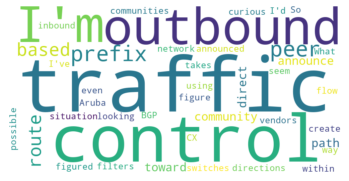

In [380]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [381]:
#wordcloud for sysadmin subreddit
sysadmin_wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(sysadmin_final_df['selftext'][0])

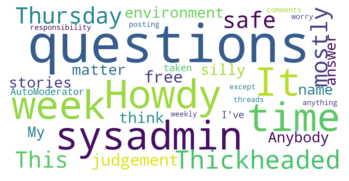

In [382]:
plt.figure()
plt.imshow(sysadmin_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

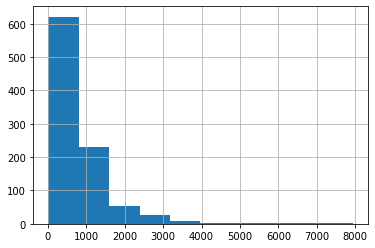

In [383]:
#number of characters present in each sentence of the subreddit sysadmin
sysadmin_final_df['selftext'].str.len().hist()

In [384]:
#average character count for subreddit sysadmin 
#word count might be more informative
sysadmin_final_df['selftext'].str.len().mean()

830.2760800842992

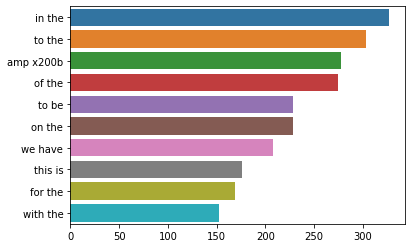

In [385]:
#top 10 ngrams for subreddit sysadmin
top_n_bigrams=get_top_ngram(sysadmin_final_df['selftext'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

In [386]:
#wordcloud for networking subreddit
networking_wordcloud = WordCloud(width=1000, height=500, 
                                 background_color="white").generate(networking_final_df['selftext'][0])

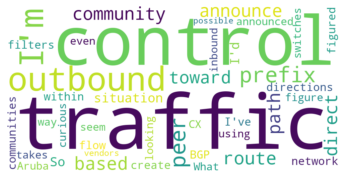

In [387]:
plt.figure()
plt.imshow(networking_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

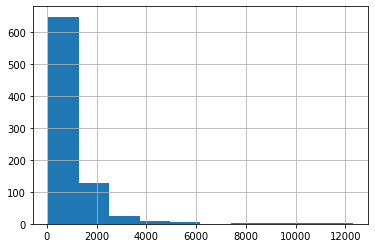

In [388]:
#number of characters present in each sentence of the subreddit networking
networking_final_df['selftext'].str.len().hist()

In [389]:
#average character count for subreddit networking 
#word count might be more informative
networking_final_df['selftext'].str.len().mean()

974.9255189255189

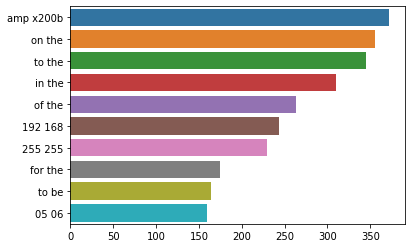

In [390]:
#top 10 ngrams for subreddit networking
top_n_bigrams=get_top_ngram(networking_final_df['selftext'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

In [391]:
#profanity count in both subreddits

In [392]:
#evidence of strong moderation in the subreddits?

In [393]:
#level of education required at subreddit

In [394]:
#awarding reddit gold, can we measure it? gold posts 'glided'

## CountVectorizer

In [395]:
vectorizer = CountVectorizer(analyzer= 'word',
                             tokenizer= None,
                             preprocessor= None,
                             stop_words = None)

In [396]:
#max features - https://stackoverflow.com/questions/46118910/scikit-learn-vectorizer-max-features 

In [397]:
train_data_features = vectorizer.fit_transform(clean_train_posts)
test_data_features = vectorizer.transform(clean_test_posts)

In [398]:
print(train_data_features.shape)

(1414, 10182)


In [399]:
print(test_data_features.shape)

(354, 10182)


In [400]:
vocab = vectorizer.get_feature_names()
print(vocab)

['aaa', 'aaaa', 'aad', 'ab', 'abandon', 'abandoned', 'abc', 'abgn', 'ability', 'abit', 'able', 'abnormal', 'abondoned', 'abruptly', 'absence', 'absolute', 'absolutely', 'absorbed', 'abstract', 'ac', 'academic', 'academy', 'accelerating', 'acceleration', 'accelerator', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'acceptsecuritycontext', 'access', 'accessable', 'accessbility', 'accessed', 'accessibility', 'accessible', 'accessing', 'accidental', 'accidentally', 'accidentially', 'accommodating', 'accompanying', 'accomplish', 'accomplishing', 'according', 'accordingly', 'account', 'accountant', 'accountid', 'accounting', 'accredited', 'accross', 'accumulate', 'accumulated', 'accurate', 'ace', 'acf', 'achieve', 'achieved', 'achieves', 'aci', 'ack', 'acked', 'ackes', 'acknowledgement', 'acks', 'acl', 'acls', 'acm', 'acquire', 'acquired', 'acquires', 'acquiring', 'acquisition', 'acrobat', 'acroexch', 'acronis', 'acronym', 'across', 'act', 'acting', 'action', 'activate', 'ac

In [401]:
X_train_cvec = pd.DataFrame(train_data_features.toarray(), columns=vectorizer.get_feature_names())
X_train_cvec.head()

,aaa,aaaa,aad,ab,abandon,abandoned,abc,abgn,ability,abit,able,abnormal,abondoned,abruptly,absence,absolute,absolutely,absorbed,abstract,ac,academic,academy,accelerating,acceleration,accelerator,accept,acceptable,acceptance,accepted,accepting,acceptsecuritycontext,access,accessable,accessbility,accessed,accessibility,accessible,accessing,accidental,accidentally,accidentially,accommodating,accompanying,accomplish,accomplishing,according,accordingly,account,accountant,accountid,accounting,accredited,accross,accumulate,accumulated,accurate,ace,acf,achieve,achieved,achieves,aci,ack,acked,ackes,acknowledgement,acks,acl,acls,acm,acquire,acquired,acquires,acquiring,acquisition,acrobat,acroexch,acronis,acronym,across,act,acting,action,activate,activated,activation,active,activecell,activedirectory,actively,activesync,activex,activity,actual,actuality,actually,acunetix,ad,adac,adafef,adam,adamant,adapter,adaptor,adblock,adblocker,adcli,add,added,adder,addin,adding,addition,additional,additionally,additoinal,addled,addons,addr,addresa,address,addressed,addressing,adequate,adfs,adi,adjacency,adjust,adjusted,administer,administered,administration,administrative,administrator,admins,admit,admx,adobe,adopted,adp,adress,adrian,adrs,adsl,adsm,adtran,aduc,adult,adva,advance,advanced,advancedcustomfields,advancement,advancing,advantage,advantageous,adventerprisek,adventure,advertise,advertised,advertisement,advertises,advertising,advertsied,advice,advise,advises,advising,advisor,advisory,ae,aepocomputerproperties,aepoleafnode,aepoprodpropsview,aer,aes,af,afa,afaik,affect,affected,affecting,affiliated,affiliation,affinity,afford,affordable,afforded,afloat,aforementioned,afraid,africa,aftermarket,afternoon,afterwards,age,aged,agency,agent,agg,aggravating,aggregate,aggregation,aggregator,aggressive,aggressively,agile,aging,agnostic,ago,agree,agreed,agreeing,agreement,agrees,ahead,ahve,ai,aia,aid,aim,aipprv,air,airbnb,airflow,aironets,airport,aisle,aita,aja,ajax,ak,aka,akin,akips,al,alarm,alb,albeit,alcatel,alert,alerted,alerting,alexma,alg,algorithm,alias,alien,alienvault,align,...,wireshark,wiring,wisdom,wise,wiser,wish,wished,wisp,wit,witch,witcher,withgoogle,within,without,withstand,witnessing,wizard,wizardry,wl,wlan,wlc,wm,wmi,wmiobject,wmware,woefully,wog,woke,wol,wonder,wondered,wonderful,wondering,wont,woot,woq,word,wording,wordpress,wordy,work,workaholic,workaround,workarounds,workbook,workcentre,workday,worked,worker,workflow,workfolders,workforce,workgroup,workhorse,working,workload,workmail,workout,workplace,worksheet,workshop,workspace,workstation,workvpn,world,worldwide,worried,worry,worrying,worse,worst,worth,worthless,worthwhile,would,wouldnt,wound,wow,wowza,wp,wpa,wpad,wpaddecision,wpaddecisionreason,wpaddetectedurl,wqk,wqkfzvefrbfvndqprnhdeqvlevlfrs,wrap,wrapper,wrapping,wreddrops,wrench,write,writer,writes,writing,written,wrong,wrongly,wrote,wscript,wshshell,wsus,wt,wtf,wtp,wundertech,wvd,wwtizujql,www,wwwrl,wwwui,xa,xauth,xb,xbabd,xc,xca,xcopy,xcp,xczajbgnvbagtak,xd,xe,xen,xeon,xerox,xffff,xg,xgigabit,xics,xive,xiz,xjckqphc,xjxq,xl,xllucjkpaihkbjdod,xlsc,xlsx,xmit,xml,xmlns,xms,xn,xnm,xoaxvnu,xot,xp,xport,xprotect,xqyqxb,xr,xserver,xt,xtc,xtm,xtor,xvy,xw,xwin,xx,xxwin,xxx,xxxnameherexxx,xxxx,xxxxnameherexxxx,xxxxwindowsagentsetup,xxxxx,xxxxxx,xxxxxxxxx,xyz,ya,yada,yah,yahoo,yaml,yanked,yard,ybfd,yc,yclc,yea,yeah,year,yearly,yechhhh,yeet,yekkxtkrbeen,yellow,yes,yesterday,yet,yield,yielded,yikes,yk,ykbebj,yml,ymo,ynripyvd,york,young,youtu,youtube,yr,ytou,ytti,yudgblpxnhhdekfkqmdovkjbz,yueq,yum,yvph,yvywg,zabbix,zabix,zaeyydqpxam,zahz,zayo,zb,zdnet,zealand,zebra,zemwkd,zenitel,zentyal,zero,zficvo,zfs,zgdounfttzhbmxbfytlmowljtgrjymlvavflbtrmuvk,zgrab,zi,zipper,zix,zl,zlyeluk,zohopublic,zone,zonedirector,zoneset,zonk,zoom,zscalar,zscaler,ztp,ztv,zuora,zwcad,zxvhpnb,zyrnkvm,zytklktelvb,zywall,zyxel
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [402]:
X_train_cvec.to_csv('../datasets/train.csv')

In [403]:
X_test_cvec = pd.DataFrame(test_data_features.toarray(), columns=vectorizer.get_feature_names())
X_test_cvec.head()

,aaa,aaaa,aad,ab,abandon,abandoned,abc,abgn,ability,abit,able,abnormal,abondoned,abruptly,absence,absolute,absolutely,absorbed,abstract,ac,academic,academy,accelerating,acceleration,accelerator,accept,acceptable,acceptance,accepted,accepting,acceptsecuritycontext,access,accessable,accessbility,accessed,accessibility,accessible,accessing,accidental,accidentally,accidentially,accommodating,accompanying,accomplish,accomplishing,according,accordingly,account,accountant,accountid,accounting,accredited,accross,accumulate,accumulated,accurate,ace,acf,achieve,achieved,achieves,aci,ack,acked,ackes,acknowledgement,acks,acl,acls,acm,acquire,acquired,acquires,acquiring,acquisition,acrobat,acroexch,acronis,acronym,across,act,acting,action,activate,activated,activation,active,activecell,activedirectory,actively,activesync,activex,activity,actual,actuality,actually,acunetix,ad,adac,adafef,adam,adamant,adapter,adaptor,adblock,adblocker,adcli,add,added,adder,addin,adding,addition,additional,additionally,additoinal,addled,addons,addr,addresa,address,addressed,addressing,adequate,adfs,adi,adjacency,adjust,adjusted,administer,administered,administration,administrative,administrator,admins,admit,admx,adobe,adopted,adp,adress,adrian,adrs,adsl,adsm,adtran,aduc,adult,adva,advance,advanced,advancedcustomfields,advancement,advancing,advantage,advantageous,adventerprisek,adventure,advertise,advertised,advertisement,advertises,advertising,advertsied,advice,advise,advises,advising,advisor,advisory,ae,aepocomputerproperties,aepoleafnode,aepoprodpropsview,aer,aes,af,afa,afaik,affect,affected,affecting,affiliated,affiliation,affinity,afford,affordable,afforded,afloat,aforementioned,afraid,africa,aftermarket,afternoon,afterwards,age,aged,agency,agent,agg,aggravating,aggregate,aggregation,aggregator,aggressive,aggressively,agile,aging,agnostic,ago,agree,agreed,agreeing,agreement,agrees,ahead,ahve,ai,aia,aid,aim,aipprv,air,airbnb,airflow,aironets,airport,aisle,aita,aja,ajax,ak,aka,akin,akips,al,alarm,alb,albeit,alcatel,alert,alerted,alerting,alexma,alg,algorithm,alias,alien,alienvault,align,...,wireshark,wiring,wisdom,wise,wiser,wish,wished,wisp,wit,witch,witcher,withgoogle,within,without,withstand,witnessing,wizard,wizardry,wl,wlan,wlc,wm,wmi,wmiobject,wmware,woefully,wog,woke,wol,wonder,wondered,wonderful,wondering,wont,woot,woq,word,wording,wordpress,wordy,work,workaholic,workaround,workarounds,workbook,workcentre,workday,worked,worker,workflow,workfolders,workforce,workgroup,workhorse,working,workload,workmail,workout,workplace,worksheet,workshop,workspace,workstation,workvpn,world,worldwide,worried,worry,worrying,worse,worst,worth,worthless,worthwhile,would,wouldnt,wound,wow,wowza,wp,wpa,wpad,wpaddecision,wpaddecisionreason,wpaddetectedurl,wqk,wqkfzvefrbfvndqprnhdeqvlevlfrs,wrap,wrapper,wrapping,wreddrops,wrench,write,writer,writes,writing,written,wrong,wrongly,wrote,wscript,wshshell,wsus,wt,wtf,wtp,wundertech,wvd,wwtizujql,www,wwwrl,wwwui,xa,xauth,xb,xbabd,xc,xca,xcopy,xcp,xczajbgnvbagtak,xd,xe,xen,xeon,xerox,xffff,xg,xgigabit,xics,xive,xiz,xjckqphc,xjxq,xl,xllucjkpaihkbjdod,xlsc,xlsx,xmit,xml,xmlns,xms,xn,xnm,xoaxvnu,xot,xp,xport,xprotect,xqyqxb,xr,xserver,xt,xtc,xtm,xtor,xvy,xw,xwin,xx,xxwin,xxx,xxxnameherexxx,xxxx,xxxxnameherexxxx,xxxxwindowsagentsetup,xxxxx,xxxxxx,xxxxxxxxx,xyz,ya,yada,yah,yahoo,yaml,yanked,yard,ybfd,yc,yclc,yea,yeah,year,yearly,yechhhh,yeet,yekkxtkrbeen,yellow,yes,yesterday,yet,yield,yielded,yikes,yk,ykbebj,yml,ymo,ynripyvd,york,young,youtu,youtube,yr,ytou,ytti,yudgblpxnhhdekfkqmdovkjbz,yueq,yum,yvph,yvywg,zabbix,zabix,zaeyydqpxam,zahz,zayo,zb,zdnet,zealand,zebra,zemwkd,zenitel,zentyal,zero,zficvo,zfs,zgdounfttzhbmxbfytlmowljtgrjymlvavflbtrmuvk,zgrab,zi,zipper,zix,zl,zlyeluk,zohopublic,zone,zonedirector,zoneset,zonk,zoom,zscalar,zscaler,ztp,ztv,zuora,zwcad,zxvhpnb,zyrnkvm,zytklktelvb,zywall,zyxel
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [404]:
X_train_cvec.shape

(1414, 10182)

## Naive Bayes

Choosing MultinomialNB since the features are all integer counts, confirmed from EDA that we cannot use GaussianNB since the features are not normally distributed.

In [405]:
nb = MultinomialNB()

In [406]:
model = nb.fit(X_train_cvec, y_train)
nb.score(X_train_cvec, y_train)

0.9483734087694484

In [407]:
accuracy = cross_val_score(nb, X_test_cvec, y_test, scoring='accuracy', cv=10)
accuracy

array([0.66666667, 0.80555556, 0.88888889, 0.88888889, 0.82857143,
       0.85714286, 0.85714286, 0.88571429, 0.85714286, 0.71428571])

In [408]:
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 82.5


In [409]:
nb.score(X_test_cvec, y_test)

0.8502824858757062

In [410]:
nb_predictions = nb.predict(X_test_cvec)

In [411]:
confusion_matrix(y_test, nb_predictions)

array([[134,  36],
       [ 17, 167]])

In [412]:
tn, fp, fn, tp = confusion_matrix(y_test, nb_predictions).ravel()

In [413]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 134
False Positives: 36
False Negatives: 17
True Positives: 167


In [414]:
#draw ROC curve for naive bayes if possible
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
#pred_proba = [i[1] for i in nb.predict_proba(X_test)]

#pred_df = pd.DataFrame({'true_values': y_test,'pred_probs': pred_proba})

## Trying out TfidVectorizer
https://www.quora.com/What-is-the-difference-between-TfidfVectorizer-and-CountVectorizer-1

In [415]:
TFID_vectorizer = TfidfVectorizer()

In [416]:
TFID_train_data_features = TFID_vectorizer.fit_transform(clean_train_posts)
TFID_test_data_features = TFID_vectorizer.transform(clean_test_posts)

In [417]:
X_train_TFID = pd.DataFrame(TFID_train_data_features.toarray(), columns=vectorizer.get_feature_names())
X_train_TFID.head()

,aaa,aaaa,aad,ab,abandon,abandoned,abc,abgn,ability,abit,able,abnormal,abondoned,abruptly,absence,absolute,absolutely,absorbed,abstract,ac,academic,academy,accelerating,acceleration,accelerator,accept,acceptable,acceptance,accepted,accepting,acceptsecuritycontext,access,accessable,accessbility,accessed,accessibility,accessible,accessing,accidental,accidentally,accidentially,accommodating,accompanying,accomplish,accomplishing,according,accordingly,account,accountant,accountid,accounting,accredited,accross,accumulate,accumulated,accurate,ace,acf,achieve,achieved,achieves,aci,ack,acked,ackes,acknowledgement,acks,acl,acls,acm,acquire,acquired,acquires,acquiring,acquisition,acrobat,acroexch,acronis,acronym,across,act,acting,action,activate,activated,activation,active,activecell,activedirectory,actively,activesync,activex,activity,actual,actuality,actually,acunetix,ad,adac,adafef,adam,adamant,adapter,adaptor,adblock,adblocker,adcli,add,added,adder,addin,adding,addition,additional,additionally,additoinal,addled,addons,addr,addresa,address,addressed,addressing,adequate,adfs,adi,adjacency,adjust,adjusted,administer,administered,administration,administrative,administrator,admins,admit,admx,adobe,adopted,adp,adress,adrian,adrs,adsl,adsm,adtran,aduc,adult,adva,advance,advanced,advancedcustomfields,advancement,advancing,advantage,advantageous,adventerprisek,adventure,advertise,advertised,advertisement,advertises,advertising,advertsied,advice,advise,advises,advising,advisor,advisory,ae,aepocomputerproperties,aepoleafnode,aepoprodpropsview,aer,aes,af,afa,afaik,affect,affected,affecting,affiliated,affiliation,affinity,afford,affordable,afforded,afloat,aforementioned,afraid,africa,aftermarket,afternoon,afterwards,age,aged,agency,agent,agg,aggravating,aggregate,aggregation,aggregator,aggressive,aggressively,agile,aging,agnostic,ago,agree,agreed,agreeing,agreement,agrees,ahead,ahve,ai,aia,aid,aim,aipprv,air,airbnb,airflow,aironets,airport,aisle,aita,aja,ajax,ak,aka,akin,akips,al,alarm,alb,albeit,alcatel,alert,alerted,alerting,alexma,alg,algorithm,alias,alien,alienvault,align,...,wireshark,wiring,wisdom,wise,wiser,wish,wished,wisp,wit,witch,witcher,withgoogle,within,without,withstand,witnessing,wizard,wizardry,wl,wlan,wlc,wm,wmi,wmiobject,wmware,woefully,wog,woke,wol,wonder,wondered,wonderful,wondering,wont,woot,woq,word,wording,wordpress,wordy,work,workaholic,workaround,workarounds,workbook,workcentre,workday,worked,worker,workflow,workfolders,workforce,workgroup,workhorse,working,workload,workmail,workout,workplace,worksheet,workshop,workspace,workstation,workvpn,world,worldwide,worried,worry,worrying,worse,worst,worth,worthless,worthwhile,would,wouldnt,wound,wow,wowza,wp,wpa,wpad,wpaddecision,wpaddecisionreason,wpaddetectedurl,wqk,wqkfzvefrbfvndqprnhdeqvlevlfrs,wrap,wrapper,wrapping,wreddrops,wrench,write,writer,writes,writing,written,wrong,wrongly,wrote,wscript,wshshell,wsus,wt,wtf,wtp,wundertech,wvd,wwtizujql,www,wwwrl,wwwui,xa,xauth,xb,xbabd,xc,xca,xcopy,xcp,xczajbgnvbagtak,xd,xe,xen,xeon,xerox,xffff,xg,xgigabit,xics,xive,xiz,xjckqphc,xjxq,xl,xllucjkpaihkbjdod,xlsc,xlsx,xmit,xml,xmlns,xms,xn,xnm,xoaxvnu,xot,xp,xport,xprotect,xqyqxb,xr,xserver,xt,xtc,xtm,xtor,xvy,xw,xwin,xx,xxwin,xxx,xxxnameherexxx,xxxx,xxxxnameherexxxx,xxxxwindowsagentsetup,xxxxx,xxxxxx,xxxxxxxxx,xyz,ya,yada,yah,yahoo,yaml,yanked,yard,ybfd,yc,yclc,yea,yeah,year,yearly,yechhhh,yeet,yekkxtkrbeen,yellow,yes,yesterday,yet,yield,yielded,yikes,yk,ykbebj,yml,ymo,ynripyvd,york,young,youtu,youtube,yr,ytou,ytti,yudgblpxnhhdekfkqmdovkjbz,yueq,yum,yvph,yvywg,zabbix,zabix,zaeyydqpxam,zahz,zayo,zb,zdnet,zealand,zebra,zemwkd,zenitel,zentyal,zero,zficvo,zfs,zgdounfttzhbmxbfytlmowljtgrjymlvavflbtrmuvk,zgrab,zi,zipper,zix,zl,zlyeluk,zohopublic,zone,zonedirector,zoneset,zonk,zoom,zscalar,zscaler,ztp,ztv,zuora,zwcad,zxvhpnb,zyrnkvm,zytklktelvb,zywall,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094516,0.0,

In [418]:
X_test_TFID = pd.DataFrame(TFID_test_data_features.toarray(), columns=vectorizer.get_feature_names())
X_test_TFID.head()

,aaa,aaaa,aad,ab,abandon,abandoned,abc,abgn,ability,abit,able,abnormal,abondoned,abruptly,absence,absolute,absolutely,absorbed,abstract,ac,academic,academy,accelerating,acceleration,accelerator,accept,acceptable,acceptance,accepted,accepting,acceptsecuritycontext,access,accessable,accessbility,accessed,accessibility,accessible,accessing,accidental,accidentally,accidentially,accommodating,accompanying,accomplish,accomplishing,according,accordingly,account,accountant,accountid,accounting,accredited,accross,accumulate,accumulated,accurate,ace,acf,achieve,achieved,achieves,aci,ack,acked,ackes,acknowledgement,acks,acl,acls,acm,acquire,acquired,acquires,acquiring,acquisition,acrobat,acroexch,acronis,acronym,across,act,acting,action,activate,activated,activation,active,activecell,activedirectory,actively,activesync,activex,activity,actual,actuality,actually,acunetix,ad,adac,adafef,adam,adamant,adapter,adaptor,adblock,adblocker,adcli,add,added,adder,addin,adding,addition,additional,additionally,additoinal,addled,addons,addr,addresa,address,addressed,addressing,adequate,adfs,adi,adjacency,adjust,adjusted,administer,administered,administration,administrative,administrator,admins,admit,admx,adobe,adopted,adp,adress,adrian,adrs,adsl,adsm,adtran,aduc,adult,adva,advance,advanced,advancedcustomfields,advancement,advancing,advantage,advantageous,adventerprisek,adventure,advertise,advertised,advertisement,advertises,advertising,advertsied,advice,advise,advises,advising,advisor,advisory,ae,aepocomputerproperties,aepoleafnode,aepoprodpropsview,aer,aes,af,afa,afaik,affect,affected,affecting,affiliated,affiliation,affinity,afford,affordable,afforded,afloat,aforementioned,afraid,africa,aftermarket,afternoon,afterwards,age,aged,agency,agent,agg,aggravating,aggregate,aggregation,aggregator,aggressive,aggressively,agile,aging,agnostic,ago,agree,agreed,agreeing,agreement,agrees,ahead,ahve,ai,aia,aid,aim,aipprv,air,airbnb,airflow,aironets,airport,aisle,aita,aja,ajax,ak,aka,akin,akips,al,alarm,alb,albeit,alcatel,alert,alerted,alerting,alexma,alg,algorithm,alias,alien,alienvault,align,...,wireshark,wiring,wisdom,wise,wiser,wish,wished,wisp,wit,witch,witcher,withgoogle,within,without,withstand,witnessing,wizard,wizardry,wl,wlan,wlc,wm,wmi,wmiobject,wmware,woefully,wog,woke,wol,wonder,wondered,wonderful,wondering,wont,woot,woq,word,wording,wordpress,wordy,work,workaholic,workaround,workarounds,workbook,workcentre,workday,worked,worker,workflow,workfolders,workforce,workgroup,workhorse,working,workload,workmail,workout,workplace,worksheet,workshop,workspace,workstation,workvpn,world,worldwide,worried,worry,worrying,worse,worst,worth,worthless,worthwhile,would,wouldnt,wound,wow,wowza,wp,wpa,wpad,wpaddecision,wpaddecisionreason,wpaddetectedurl,wqk,wqkfzvefrbfvndqprnhdeqvlevlfrs,wrap,wrapper,wrapping,wreddrops,wrench,write,writer,writes,writing,written,wrong,wrongly,wrote,wscript,wshshell,wsus,wt,wtf,wtp,wundertech,wvd,wwtizujql,www,wwwrl,wwwui,xa,xauth,xb,xbabd,xc,xca,xcopy,xcp,xczajbgnvbagtak,xd,xe,xen,xeon,xerox,xffff,xg,xgigabit,xics,xive,xiz,xjckqphc,xjxq,xl,xllucjkpaihkbjdod,xlsc,xlsx,xmit,xml,xmlns,xms,xn,xnm,xoaxvnu,xot,xp,xport,xprotect,xqyqxb,xr,xserver,xt,xtc,xtm,xtor,xvy,xw,xwin,xx,xxwin,xxx,xxxnameherexxx,xxxx,xxxxnameherexxxx,xxxxwindowsagentsetup,xxxxx,xxxxxx,xxxxxxxxx,xyz,ya,yada,yah,yahoo,yaml,yanked,yard,ybfd,yc,yclc,yea,yeah,year,yearly,yechhhh,yeet,yekkxtkrbeen,yellow,yes,yesterday,yet,yield,yielded,yikes,yk,ykbebj,yml,ymo,ynripyvd,york,young,youtu,youtube,yr,ytou,ytti,yudgblpxnhhdekfkqmdovkjbz,yueq,yum,yvph,yvywg,zabbix,zabix,zaeyydqpxam,zahz,zayo,zb,zdnet,zealand,zebra,zemwkd,zenitel,zentyal,zero,zficvo,zfs,zgdounfttzhbmxbfytlmowljtgrjymlvavflbtrmuvk,zgrab,zi,zipper,zix,zl,zlyeluk,zohopublic,zone,zonedirector,zoneset,zonk,zoom,zscalar,zscaler,ztp,ztv,zuora,zwcad,zxvhpnb,zyrnkvm,zytklktelvb,zywall,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [419]:
X_train_TFID.shape

(1414, 10182)

In [420]:
X_test_TFID.shape

(354, 10182)

## Gridsearch CV and Pipeline

https://towardsdatascience.com/nlp-with-pipeline-gridsearch-5922266e82f4

In [524]:
#setting up Naive Bayes
tvc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mb', MultinomialNB())
])

#setting up the random forest
rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])
#setting up logistic regression
#log_pipe = Pipeline([
#    ('tvec', TfidfVectorizer()),
#    ('lr', LogisticRegression())
#])

#fit
tvc_pipe.fit(clean_train_posts, y_train)
rf_pipe.fit(clean_train_posts, y_train)
#log_pipe.fit(clean_train_posts, y_train)

#setting params for TFIDF Vectorizer gridsearch
tf_params = {
    'tvec__ngram_range': [(1,1), (1,2), (2,2)]
}

#setting up randomforest params
rf_params = {
    'tvec__max_features': [2000],
    'tvec__ngram_range': [(1,1), (1,2), (2,2)],
    'rf__max_depth': [1000],
    'rf__min_samples_split': [100],
    'rf__max_leaf_nodes': [None]
}

#setting up logistic regression params
#log_params = {
#    'lr__penalty': ['l1', 'l2'],
#    'lr__C': [1, 5, 10],
#    'lr__max_iter': [20, 50, 100],
#    'tvec__max_df': np.linspace(0.1, 1, 10),
#    'tvec__binary': [True]
#}


# Setting up GridSearch for Randomforest
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv = 5, verbose = 1, n_jobs = -1)
# Setting up GridSearch for Naive Bayes
tvc_gs = GridSearchCV(tvc_pipe, param_grid=tf_params, cv = 5, verbose =1, n_jobs = -1)
# Setting up Gridsearch for logistic regression
#log_gs = GridSearchCV(log_pipe, param_grid=log_params, cv = 5, verbose =1, n_jobs = -1)

# Fitting Randomforest CV GS
rf_gs.fit(clean_train_posts, y_train)
# Fitting TVC GS
tvc_gs.fit(clean_train_posts, y_train)
# fitting logistic regression GS
#log_gs.fit(clean_train_posts, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
exception calling callback for <Future at 0x7fc633a85d90 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fi

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [ ]:
# Scoring Training data on TFIDFVectorizer, Naive Bayes
print(tvc_gs.score(clean_train_posts, y_train))
print(tvc_gs.best_estimator_)

In [512]:
pd.DataFrame(tvc_gs.cv_results_)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [513]:
# Scoring Test data on TFIDFVectorizer, Naive Bayes
tvc_gs.score(clean_test_posts, y_test)

AttributeError: 'GridSearchCV' object has no attribute 'scorer_'

In [514]:
# Scoring Training data on TFIDFVectorizer, RandomForest
rf_gs.score(clean_train_posts, y_train)
print(rf_gs.best_params_)
print(rf_gs.best_estimator_)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [515]:
pd.DataFrame(rf_gs.cv_results_)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [516]:
# Checking Test score on TFIDFVectorizer, RandomForest
rf_gs.score(clean_test_posts, y_test)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [517]:
tvc_gs.predict(clean_test_posts)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [507]:
rf_pipe.steps[1][1].feature_importances_

array([5.17890692e-05, 0.00000000e+00, 2.01558251e-05, ...,
       1.51881604e-05, 0.00000000e+00, 2.50484360e-05])

In [508]:
rf_pipe.steps[1][1].predict_proba

<bound method ForestClassifier.predict_proba of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [509]:
#top random forest features in descending order of importance
tvc_title = pd.DataFrame(rf_pipe.steps[1][1].feature_importances_, 
                         tvc_pipe.steps[0][1].get_feature_names(), columns=['importance'])
tvc_title.sort_values('importance', ascending = False).head(10)

,importance
switch,0.022749
cisco,0.022727
router,0.012831
window,0.009108
ip,0.009087
traffic,0.008742
user,0.008296
route,0.007927
port,0.007908
packet,0.007148


In [510]:
#least important features and see if it is 'stop words' worthy
tvc_title.sort_values('importance', ascending = True).head(20)

,importance
lsp,0.0
increased,0.0
silent,0.0
incorrectly,0.0
silently,0.0
incorporating,0.0
incorporate,0.0
inconspicuousitguy,0.0
inconsistent,0.0
inconsistency,0.0


## Logistic Regression 

In [441]:
logreg = LogisticRegression()

In [442]:
logreg.fit(X_train_cvec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [443]:
logreg.score(X_train_cvec, y_train)

1.0

In [444]:
accuracy = cross_val_score(logreg, X_test_cvec, y_test, scoring='accuracy', cv=10)
accuracy

array([0.69444444, 0.72222222, 0.75      , 0.77777778, 0.88571429,
       0.8       , 0.82857143, 0.82857143, 0.77142857, 0.85714286])

In [445]:
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 79.15873015873015


In [446]:
logreg_predictions = logreg.predict(X_test_cvec)

In [447]:
confusion_matrix(y_test, logreg_predictions)

array([[138,  32],
       [ 19, 165]])

In [448]:
logreg.score(X_test_cvec, y_test)

0.8559322033898306